### TF-IDF Classifier to classify Fusion Tickets

In [2]:
import warnings
def warn(*args, **kwargs): 
    pass
warnings.warn = warn

#### Import Important Libraries

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import itertools

#### Import Important Class and Functions

In [69]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#from pandas_ml import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### Import Dataset

In [70]:
df_FIN=pd.read_excel('./FIN_AUG_SEP.xlsx',encoding='utf-8')

In [71]:
len(df_FIN)

14360

In [72]:
df_FIN=df_FIN.dropna()


In [73]:
len(df_FIN)

13617

In [74]:
df_SCM=pd.read_excel('./SCM_AUG_SEP.xlsx',encoding='utf-8')

In [75]:
len(df_SCM)

9505

In [76]:
df_SCM=df_SCM.dropna()

In [77]:
len(df_SCM)

9159

In [78]:
list_df=[df_FIN,df_SCM]

In [79]:
df=pd.concat(list_df,axis=0)

In [80]:
print(len(df.index))

22776


In [81]:
df.head(2)

,Bugged,Severity,Product Family,Product Area,Product ID,Product,Component,Sub Component,Product Version,Root Cause,SR,Known Issue,Reason Code,Summary,Status,Substatus,Last Updated On,Date Opened,Days Open,Date Closed
0,No,4-Minimal,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Set Up FCR-Define Ledgers,Manage Accounting and Reporting Sequences,11.12.1.0.0,Cloud-Post Go Live,1,Unspecified,13 Documentation,Creation of account and account code combination,Closed,Resolved with Solution,2018-08-29 19:26:25,2018-08-22 07:01:15,7,2018-08-29 14:52:48
1,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Invoices-Audit Invoices,Manage Payables Invoices,11.13.18.02.0,Cloud-Post Go Live,2,Yes,"14 Undetermined,Cust Abandoned",[IMPL SPT] An application error occurred on ed...,Closed,No fault found,2018-08-24 18:38:19,2018-08-10 08:46:14,7,2018-08-17 16:29:01


In [82]:
df['Root Cause'].value_counts()

Cloud-Implementation             14009
Cloud-Post Go Live                5514
Cloud-Provisioning                1402
Software-Maintain                  598
Cust Engmt - Customer/Partner      394
Cloud-Special Events               385
Software-Install                   322
Software-Upgrade                    68
Cust Engmt - Development            38
Cust Engmt - Support                30
Hardware                            10
SR Link                              1
3-18260575351                        1
3-18307149679                        1
3-18201600121                        1
3-18246699141                        1
3-17922331161                        1
Name: Root Cause, dtype: int64

In [83]:
df.columns=df.columns.astype('str')

In [84]:
df=df.drop_duplicates().reset_index(drop=True)

In [85]:
print(len(df.index))

22776


In [86]:
df.columns=df.columns.astype(str)

In [87]:
print(sum(df['SR'].isna()))


0


In [88]:
df=df.loc[df['SR'].dropna()]

In [89]:
len(df)

22776

In [90]:
 print(sum(df['SR'].isnull()))
# df=df.loc[~df['SR'].isnull()]

0


In [91]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [92]:
list(df.Root_Cause.unique())

['Cloud-Post Go Live',
 'Cloud-Implementation',
 'Cloud-Provisioning',
 'Cloud-Special Events',
 'Software-Maintain',
 'Cust Engmt - Customer/Partner',
 'Software-Install',
 'Cust Engmt - Development',
 'Software-Upgrade',
 'Hardware',
 'Cust Engmt - Support',
 '3-17922331161',
 '3-18307149679',
 '3-18260575351']

In [93]:
df=df.dropna()

In [94]:
len(df.index)

22776

### Text Classification

In [95]:
df.Summary=df.Summary.apply(lambda x : str(x))

In [96]:
df.Summary=df.Summary.apply(lambda x : x.encode('ascii',errors='ignore').decode())

In [97]:
df.head(100)

,Bugged,Severity,Product_Family,Product_Area,Product_ID,Product,Component,Sub_Component,Product_Version,Root_Cause,SR,Known_Issue,Reason_Code,Summary,Status,Substatus,Last_Updated_On,Date_Opened,Days_Open,Date_Closed
1,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Invoices-Audit Invoices,Manage Payables Invoices,11.13.18.02.0,Cloud-Post Go Live,2,Yes,"14 Undetermined,Cust Abandoned",[IMPL SPT] An application error occurred on ed...,Closed,No fault found,2018-08-24 18:38:19,2018-08-10 08:46:14,7,2018-08-17 16:29:01
2,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Financial Reporting and Analysis,Prepare Financial Reports,11.12.1.0.0,Cloud-Implementation,3,Yes,01 Product Defects,We can not do the drilldown from the defined f...,Closed,Resolved with Solution,2018-08-02 01:40:04,2018-07-25 16:15:11,7,2018-08-01 23:47:24
3,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Set Up FCR-Define Ledgers,Manage Ledgers and Balancing Segment Value Ass...,11.13.18.02.0,Cloud-Post Go Live,4,Yes,07 Setup / Configuration,Remove the assigned balancing segment from a l...,Closed,Resolved with Workaround,2018-08-23 16:39:27,2018-08-09 06:18:46,7,2018-08-16 13:49:48
4,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Accounts Payable Balances-Close Payable...,Manage Payables Accounting Periods,11.13.18.02.0,Cloud-Post Go Live,5,No,07 Setup / Configuration,Unable to activate AP Journal Entry Rule Set X...,Closed,Resolved with Solution,2018-09-06 16:39:41,2018-08-23 07:46:37,7,2018-08-30 15:15:14
5,No,3-Standard,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10418,Oracle Fusion Receivables Cloud Service,Setup Module,UNSPECIFIED,11.13.18.02.0,Cloud-Post Go Live,6,Unspecified,01 Product Defects,"""Cannot insert record more than once"" on loadi...",Closed,Resolved with Workaround,2018-08-14 17:44:58,2018-07-31 07:19:34,7,2018-08-07 14:49:06
6,No,3-Standard,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10403,Oracle Fusion Financials Common Module Cloud S...,Functional Setup Manager,UNSPECIFIED,11.13.18.02.0,Cloud-Post Go Live,7,Yes,07 Setup / Configuration,How to create common Lookup under Common Looku...,Closed,Resolved with Solution,2018-09-05 02:31:52,2018-08-21 16:55:38,7,2018-08-29 00:16:36
7,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Financial Reporting and Analysis,Prepare Financial Reports,11.13.18.02.0,Cloud-Post Go Live,8,Unspecified,07 Setup / Configuration,Unable to use Smartview post R13 upgrade,Closed,No fault found,2018-08-30 19:17:42,2018-08-23 07:33:12,7,2018-08-30 14:46:26
8,No,1-Critical,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10405,Oracle Fusion General Ledger Cloud Service,Create and Manage Journals,Manage Journals,11.13.18.02.0,Cloud-Implementation,9,Yes,"05 Performance, Sizing",Cannot Open Journal Page (Error 504),Closed,No fault found,2018-08-23 13:40:13,2018-08-09 03:37:10,7,2018-08-16 10:49:54
9,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10420,Oracle Fusion Payables Cloud Service,Manage Payments-Prepare and Record Payments,Manage Payables Payments,11.13.18.02.0,Cloud-Post Go Live,10,No,02 Enhancement Requests,Single Consolidated payment for Multiple Busin...,Closed,Enhancement Request,2018-08-20 19:23:56,2018-08-13 05:12:00,7,2018-08-20 12:14:08
10,No,2-Significant,Oracle Software Cloud,Oracle Enterprise Resource Planning Cloud,10400,Oracle Fusion Tax Cloud Service,Set Up FCR-Define Third-Party Tax Configuration,Manage Third Party Site Tax Profiles,11.13.18.05.0,Cloud-Post Go Live,11,Unspecified,12 Usability/Training-End Use

In [98]:
list_nonchar=['_','-','[',']',':',')','~','(','.',',','\"','\'','/','{','}','%','?','0','1','2','3','4','5','6','7','8','9']

In [99]:
def replace(list_nc):
    for text in df:
        for char in list_nc:
            df.Summary=df.Summary.apply(lambda x : x.replace(char, ' '))

In [100]:
replace(list_nonchar)

In [101]:
df_dict=df[['Summary','Root_Cause']]
len(df_dict)

22776

In [102]:
df_dict.head(2)

,Summary,Root_Cause
1,IMPL SPT An application error occurred on ed...,Cloud-Post Go Live
2,We can not do the drilldown from the defined f...,Cloud-Implementation


In [103]:
len(df_dict)

22776

In [104]:
df_dict.Root_Cause.unique()

array(['Cloud-Post Go Live', 'Cloud-Implementation', 'Cloud-Provisioning',
       'Cloud-Special Events', 'Software-Maintain',
       'Cust Engmt - Customer/Partner', 'Software-Install',
       'Cust Engmt - Development', 'Software-Upgrade', 'Hardware',
       'Cust Engmt - Support', '3-17922331161', '3-18307149679',
       '3-18260575351'], dtype=object)

In [105]:
# df_dict=df_dict[~df_dict.Root_Cause.isin(['3-17922331161',
#  '3-18307149679',
#  '3-18260575351'])]

In [106]:
df_dict=df_dict[~df_dict.Root_Cause.isin(['3-17922331161',
 '3-18307149679',
 '3-18260575351','3-18201600121', 'SR Link', '3-18246699141'])]

In [107]:
len(df_dict)

22772

In [108]:
df_dict['text'] = df_dict['Summary'].astype(str)

In [109]:
df_dict=df_dict.drop(columns=['Summary'])

In [110]:
df_dict.text=df_dict.text.apply(lambda x : x.lower())

In [112]:
df_dict.head()

,Root_Cause,text
1,Cloud-Post Go Live,impl spt an application error occurred on ed...
2,Cloud-Implementation,we can not do the drilldown from the defined f...
3,Cloud-Post Go Live,remove the assigned balancing segment from a l...
4,Cloud-Post Go Live,unable to activate ap journal entry rule set x...
5,Cloud-Post Go Live,cannot insert record more than once on loadi...


In [113]:
df_dict.text=df_dict.text.str.replace('\d+', '')

In [114]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [115]:
def preprocess(document, lemma=True):
    document = document.lower()
    words = word_tokenize(document)
    words = [word for word in words if word not in stopwords.words("english")]
    if lemma:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    else:
        words = [stemmer.stem(word) for word in words]
    document = " ".join(words)
    return document

In [116]:
df_dict.groupby('Root_Cause').count().sort_values(by='text',ascending=False)

,text
Root_Cause,
Cloud-Implementation,12970
Cloud-Post Go Live,6417
Cloud-Provisioning,1499
Software-Maintain,605
Cust Engmt - Customer/Partner,425
Cloud-Special Events,396
Software-Install,315
Software-Upgrade,54
Cust Engmt - Support,40


In [117]:
df_dict.text=df_dict.text.apply(lambda x : preprocess(x))

In [52]:
df_dict.head()

,Root_Cause,text
1,Cloud-Post Go Live,impl spt application error occur edit distribu...
2,Cloud-Implementation,drilldown define financial report
3,Cloud-Post Go Live,remove assign balance segment legal entity
4,Cloud-Post Go Live,unable activate ap journal entry rule set xla
5,Cloud-Post Go Live,insert record load nd receipt batch use spread...


In [53]:
word_dist=pd.DataFrame(pd.Series(' '.join(df_dict.text).split()).value_counts()).reset_index(drop=False)

In [54]:
word_dist=word_dist.rename(columns={'index':'word',0:'freq'})

In [53]:
wldf=word_dist

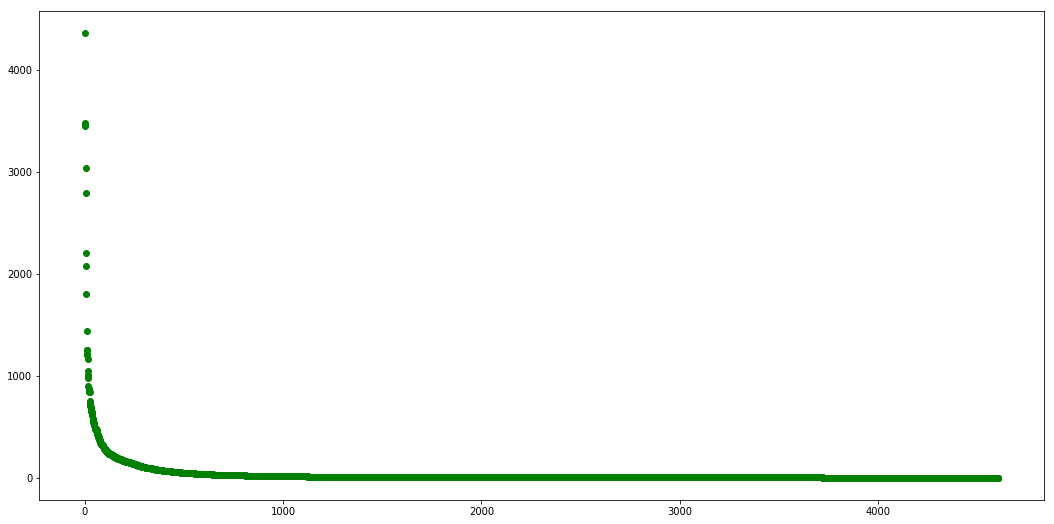

In [56]:
plt.figure(figsize=(18,9))
plt.scatter(x=wldf.index,y=wldf.freq,c='g')

In [57]:
wldf.head()

,word,freq
0,invoice,4365
1,impl,3484
2,spt,3447
3,error,3035
4,account,2792


In [58]:
wldf.tail()

,word,freq
4603,facility,1
4604,movements,1
4605,liabilities,1
4606,absence,1
4607,tra,1


In [59]:
len(wldf.index)

4608

In [60]:
print(len(wldf[wldf.freq<2]))
print(len(wldf[wldf.freq>4000]))

886
1


In [61]:
wldf_new=wldf#[~wldf.freq.isin(wldf.freq.iloc[:1])]
#wldf_new=wldf_new[~wldf_new.freq.isin(['1'])]

In [62]:
def rem_words(list_name):
    for i in list_name:
        if len(i)==1:
            list_name.remove(i)
        #elif len(i)==2:
        #    list_name.remove(i)
    return(list_name)

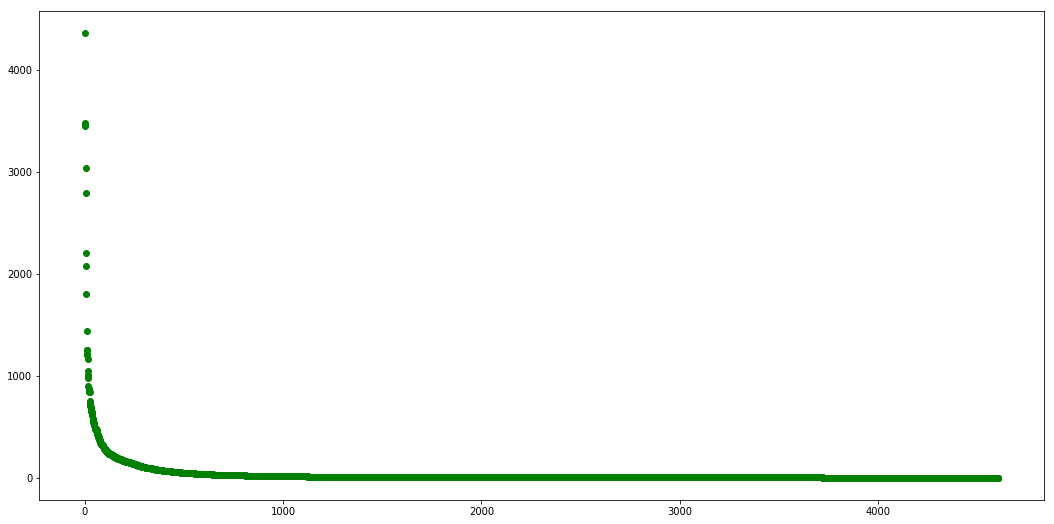

In [63]:
plt.figure(figsize=(18,9))
plt.scatter(x=wldf_new.index,y=wldf_new.freq,c='g')
#plt.yscale('log')

In [64]:
len(wldf_new.index)

4608

In [65]:
list_words=list(wldf_new.word)

In [66]:
list_words=rem_words(list_words)

In [67]:
list_words[:5]

['invoice', 'impl', 'spt', 'error', 'account']

In [68]:
#wldf_excU=wldf[wldf.freq.isin(wldf.freq.iloc[:1])]
#wldf_excL=wldf[wldf.freq.isin(['1'])]

In [69]:
#wldf_excL.head()

In [70]:
#wldf_excU

In [71]:
#wldf_exc=wldf_excU#pd.concat([wldf_excL,wldf_excU],axis=0)
#print(wldf_exc[:2])
#print(wldf_exc[-2:])

In [72]:
#wldf_exc_list=list(wldf_exc.word)

In [73]:
#wldf_exc_list[:5]

In [74]:
#def exc_list_word(txt):
#    querywords = txt.split()
#    resultwords  = [word for word in querywords if word.lower() not in wldf_exc_list]
#    result = ' '.join(resultwords)
#    return(result)

In [75]:
#df_dict.text=df_dict.text.apply(lambda x : exc_list_word(x))

In [76]:
df_dict.text.head()

1    impl spt application error occur edit distribu...
2                    drilldown define financial report
3           remove assign balance segment legal entity
4        unable activate ap journal entry rule set xla
5    insert record load nd receipt batch use spread...
Name: text, dtype: object

In [77]:
#df_dict.to_excel(FILE_IMP)

In [78]:
##writer = pd.ExcelWriter('pandas_simple.xlsx',engine='xlsxwriter')

In [79]:
#df_dict.to_excel(writer, sheet_name='Sheet1')

In [80]:
#writer.save()

#### TFIDF Classifier model

In [55]:
x_train, x_test, y_train, y_test = train_test_split(df_dict.text, df_dict.Root_Cause,test_size=0.25,random_state=50)

In [56]:
def tokenizer(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [stemmer.stem(wordnet_lemmatizer.lemmatize(token)) for token in tokens]
    return tokens

In [57]:
TFIDF = TfidfVectorizer(stop_words='english', tokenizer = tokenizer, preprocessor=preprocess)

In [58]:
training_data = TFIDF.fit_transform(x_train)

In [59]:
training_output = y_train

In [60]:
rf_mod = RandomForestClassifier(n_estimators=150)

In [61]:
rf_mod.fit(training_data,training_output)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
test_data=x_test.values

In [63]:
result=rf_mod.predict(TFIDF.transform(test_data))

In [64]:
result

array(['Cloud-Provisioning', 'Cloud-Implementation',
       'Cloud-Implementation', ..., 'Cloud-Implementation',
       'Cloud-Post Go Live', 'Cloud-Implementation'], dtype=object)

In [65]:
testing_data=y_test.values

In [66]:
accuracy_score(result,testing_data)

0.8264535394343931

In [67]:
confusion_matrix(result,testing_data)

array([[3076,  504,  123,   34,   22,    0,    2,    0,   30,   40,    3],
       [ 152, 1099,   29,    3,    5,    1,    2,    0,    8,    8,    0],
       [   7,    4,  232,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,    0,   60,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,    0,    0,   65,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    8,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    8,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    2,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,   51,    0,    0],
       [   5,    0,    1,    0,    2,    0,    0,    0,    0,   95,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    9]],
      dtype=int64)

In [95]:
print(classification_report(result,testing_data))

                               precision    recall  f1-score   support

         Cloud-Implementation       0.95      0.80      0.87      3825
           Cloud-Post Go Live       0.69      0.84      0.76      1318
           Cloud-Provisioning       0.60      0.95      0.74       243
         Cloud-Special Events       0.62      0.95      0.75        63
Cust Engmt - Customer/Partner       0.69      0.98      0.81        66
     Cust Engmt - Development       0.89      1.00      0.94         8
         Cust Engmt - Support       0.67      1.00      0.80         8
                     Hardware       1.00      1.00      1.00         2
             Software-Install       0.57      0.98      0.72        52
            Software-Maintain       0.66      0.95      0.78        99
             Software-Upgrade       0.75      1.00      0.86         9

                  avg / total       0.86      0.83      0.83      5693



#### Predict Root_Cause Family for new tickets

In [120]:
new_ticket_list=['Error while using Oracle Cloud','Invoice Email Address" Required for EFTZ-DEV2 environment for Markel']

In [121]:
#Dictionary format
def predict_classify_dict(new_tickets,lemma=True):
    for document in new_tickets:
        document = document.lower()
        words = word_tokenize(document)
        words = [word for word in words if word not in stopwords.words("english")]
        if lemma:
            words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
        else:
            words = [stemmer.stem(word) for word in words]
        document = " ".join(words)
        document=re.sub('[^0-9a-zA-Z]+', ' ',document)
    rc_classify=rf_mod.predict(TFIDF.transform(new_tickets))
    dict_classify=dict(itertools.zip_longest(new_tickets,rc_classify))
    return(dict_classify)

In [122]:
#DataFrame format
def predict_classify_df(new_tickets,lemma=True):
    for document in new_tickets:
        document = document.lower()
        words = word_tokenize(document)
        words = [word for word in words if word not in stopwords.words("english")]
        if lemma:
            words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
        else:
            words = [stemmer.stem(word) for word in words]
        document = " ".join(words)
        document=re.sub('[^0-9a-zA-Z]+', ' ',document)
    rc_classify=rf_mod.predict(TFIDF.transform(new_tickets))
    df=pd.DataFrame(rc_classify,new_tickets)
    df=df.reset_index().rename(columns={'index':'Summary',0:'Class'})
    return(df)

In [123]:
predict_classify_df(new_ticket_list)

['Error while using Oracle Cloud', 'Invoice Email Address" Required for EFTZ-DEV2 environment for Markel']


,Summary,Class
0,Error while using Oracle Cloud,Cloud-Post Go Live
1,"Invoice Email Address"" Required for EFTZ-DEV2 ...",Cloud-Implementation


In [100]:
predict_classify_dict(new_ticket_list)

{'Error while using Oracle Cloud': 'Cloud-Implementation',
 'Invoice Email Address" Required for EFTZ-DEV2 environment for Markel': 'Cloud-Implementation'}